In [40]:
%config Completer.use_jedi = False

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import matplotlib.animation as animation
from IPython import display
import tqdm
import metpy.calc as mpcalc
import pyproj as proj
from regrid import regrid
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from cartoplot import cartoplot
import metpy
print(metpy.__version__)
from metpy.units import units
import pickle
from netCDF4 import Dataset
import numpy as np
from tools import lonlat_to_xy
import datetime
import mask
from calendar import monthrange

1.0


# Get generic data

In [14]:
e0 = datetime.date(1900,1,1)

with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)

ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

ERA_x_grid, ERA_y_grid = lonlat_to_xy(ERA5_lon_grid, ERA5_lat_grid,hemisphere='n')

dx, dy = mpcalc.lat_lon_grid_deltas(ERA5_lon_grid, ERA5_lat_grid)

cos_lons, sin_lons = np.cos(np.deg2rad(ERA5_lon_grid)), np.sin(np.deg2rad(ERA5_lon_grid))

points = np.column_stack((ERA_x_grid.ravel(),ERA_y_grid.ravel()))

tri = Delaunay(points)  # Compute the triangulation

# Get metpy grid vars for ease grid

In [24]:
ease_lons, ease_lats = mask.get('lon'), mask.get('lat')

ease_dx, ease_dy = mpcalc.lat_lon_grid_deltas(ease_lons, ease_lats)

crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic
args = proj.Proj(proj="aeqd", lat_0=90, lon_0=0, datum="WGS84", units="m")

xout, yout = proj.transform(crs_wgs, args, np.array(ease_lons),np.array(ease_lats))

ease_dx = abs(ease_dx); ease_dy = abs(ease_dy)

ease_cos_lons, ease_sin_lons = np.cos(np.deg2rad(ease_lons)), np.sin(np.deg2rad(ease_lons))

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

# Process annual ERA5 files

In [ ]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files/'

for year in reversed(range(1992,2021,1)):
    
    print(year)
    with Dataset(f'/media/robbie/TOSHIBA EXT/E5/{year}.nc') as ERA5_data:
       
    
#         print(ERA5_data['expver'][1])
        d=0
        for month in range(1,13):
                        
            days_in_month = monthrange(year,month)[1]            
            
            if year != 2020:
                
                v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8])
                u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8])
                msl = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8])
            
            elif (year == 2020) & (month < 12):

                v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8,0])
                u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8,0])
                msl = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8,0])
                
            else:            
    
                v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8,1])
                u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8,1])
                msl = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8,1])

            
            t = np.array(ERA5_data['time'][d*8:(d+days_in_month)*8])

            d += days_in_month       

            dates = [e0 + datetime.timedelta(hours=int(h)) for h in t]
            
            ####### Regrid msl to EASE grid #######

            ease_msl = np.zeros((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]))
            ease_u10 = np.zeros((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]))
            ease_v10 = np.zeros((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]))
            
            for i in range(ease_u10.shape[0]):
#             for i in range(3):
                
                interpolator = LinearNDInterpolator(tri, msl[i].ravel())
                ease_msl[i] = interpolator((xout,yout))

                interpolator = LinearNDInterpolator(tri, u10[i].ravel())
                ease_u10[i] = interpolator((xout,yout))

                interpolator = LinearNDInterpolator(tri, v10[i].ravel())
                ease_v10[i] = interpolator((xout,yout))

            x10 = np.multiply(ease_u10,ease_cos_lons) - np.multiply(ease_v10,ease_sin_lons)
            y10 = np.multiply(ease_u10,ease_sin_lons) + np.multiply(ease_v10,ease_cos_lons)

            x10 = x10* units.meter / units.second
            y10 = y10* units.meter / units.second

            vort_3d_array = np.zeros(x10.shape)
            lapl_3d_array = np.zeros(x10.shape)
            vort_monthlies = np.zeros((12,x10.shape[1],x10.shape[2]))

            for i in range(x10.shape[0]):
#             for i in range(3):

                vort = np.array(mpcalc.vorticity(x10[i], y10[i], dx= ease_dx,dy= ease_dy))*1e6
                lapl = mpcalc.laplacian(ease_msl[i]*1e5,deltas=(ease_dy,ease_dx))
                
                vort_3d_array[i] = vort
                lapl_3d_array[i] = lapl*1e5

            vort_mon_ave = np.nanmean(vort_3d_array,axis=0)

            ds = xr.Dataset( data_vars={'vort_3hr':(['hrs','x','y'],vort_3d_array.astype(np.float32)),
                                        'lapl_3hr':(['hrs','x','y'],lapl_3d_array.astype(np.float32)),
                                        'vort_ave':(['x','y'],vort_mon_ave.astype(np.float32))},

                             coords =  {'lon':(['x','y'],ease_lons),
                                        'lat':(['x','y'],ease_lats),
                                        'hrs_since_1900':(['hrs'],t)})

            ds.to_netcdf(f'{data_dir}{year}{str(month).zfill(2)}.nc')

2020


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


2019
2018
2017
2016
2015
2014
2013
2012
2011
2010
2009
2008
2007
2006
2005
2004
2003
2002
2001
2000
1999
1998
1997
1996
1995


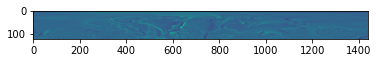

In [10]:
plt.imshow(vort)

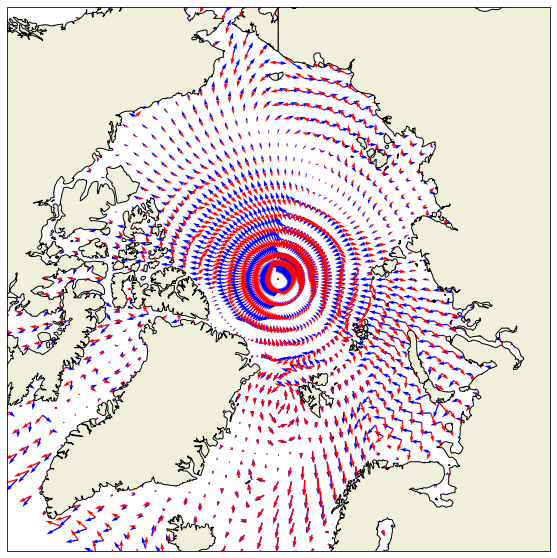

In [99]:
x10 = np.multiply(u10,cos_lons) - np.multiply(v10,sin_lons)
y10 = np.multiply(u10,sin_lons) + np.multiply(v10,cos_lons)

s1 = 5
s2 = 15

fig = plt.figure(figsize=(10,10))


ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())  

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)


ax.quiver(ERA5_lon_grid[::s1,::s2],
          ERA5_lat_grid[::s1,::s2],
          u10[0][::s1,::s2],
          v10[0][::s1,::s2],
          transform=ccrs.PlateCarree(),
          scale=500,color='b')

ax.quiver(ERA5_lon_grid[::s1,::s2],
          ERA5_lat_grid[::s1,::s2],
          x10[0][::s1,::s2],
          y10[0][::s1,::s2],
          transform=ccrs.PlateCarree(),
          scale=500,color='r')


# plt.quiver(ERA_x_grid[::s1,::s2], ERA_y_grid[::s1,::s2],
#           np.[0][::s1,::s2], np.array(y10)[0][::s1,::s2],scale=500,color='r')

In [85]:
v10[0].shape

(121, 1440)

In [83]:
cartoplot(ERA5_lon_grid, ERA5_lat_grid, np.cross(u10[0],v10[0]))



ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [87]:
x = np.array([[1,2,3], [4,5,6]])
y = np.array([[4,5,6], [1,2,3]])
np.cross(x10[0], y10[0])


ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

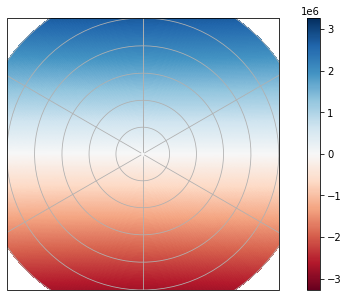

In [69]:
dzdy, dzdx = mpcalc.gradient(msl[-1], deltas=(dy, dx))

cartoplot(ERA5_lon_grid,ERA5_lat_grid,ERA_y_grid,land=False,color_scheme='RdBu')

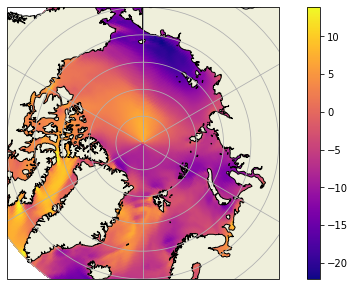

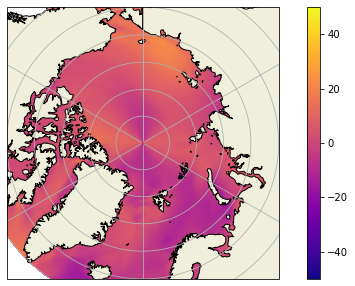

In [59]:
cartoplot(ERA5_lon_grid, ERA5_lat_grid, u10[10])

# vort = np.array(mpcalc.vorticity(u10[10], v10[10], dx=dx, dy=dy))*1e6

cartoplot(ERA5_lon_grid, ERA5_lat_grid, np.array(x10[10]), land=True, color_scale=(-50,50))

In [27]:
import mask

In [28]:
from regrid import regrid

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [82]:
big_array = np.zeros((msl.shape[0], ease_lons.shape[0], ease_lats.shape[1]))

for i in [-1]:
    
    ease_msl = regrid(msl[i],ERA5_lon_grid,ERA5_lat_grid,ease_lons,ease_lats,method='linear')
    
    big_array[i] = mpcalc.laplacian(ease_msl*1e5,deltas=(ease_dy,ease_dx))
    
m_array = np.mean(big_array,axis=0)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  from ipykernel import kernelapp as app
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ValueError: invalid shape for input data points

In [139]:
plt.hist(ease_lons)

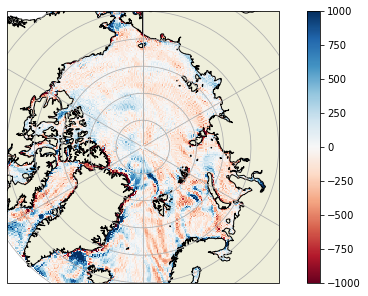

In [47]:


lapl = mpcalc.laplacian(ease_msl*1,deltas=(ease_dy,ease_dx))

laplim=1000
cartoplot(ease_lons,
          ease_lats,
#           ease_msl,
#           np.array(ease_dy),
          lapl*2e10,
          land=True,
          color_scale=(-laplim,laplim),
          color_scheme='RdBu')

In [68]:
ease_u10 = regrid(u10[-1],ERA5_lon_grid,ERA5_lat_grid,ease_lons,ease_lats,method='linear')
ease_v10 = regrid(v10[-1],ERA5_lon_grid,ERA5_lat_grid,ease_lons,ease_lats,method='linear')

In [69]:
cos_lons, sin_lons = np.cos(np.deg2rad(ease_lons)), np.sin(np.deg2rad(ease_lons))

ease_x10 = np.multiply(ease_u10,cos_lons) - np.multiply(ease_v10,sin_lons)
ease_y10 = np.multiply(ease_u10,sin_lons) + np.multiply(ease_v10,cos_lons)


ease_x10 = ease_x10* units.meter / units.second
ease_y10 = ease_y10* units.meter / units.second

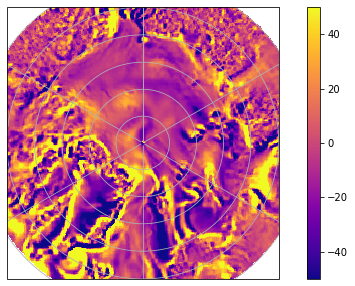

In [70]:
vort = np.array(mpcalc.vorticity(ease_x10, ease_y10, dx=ease_dx, dy=ease_dy))*1e6

cartoplot(ease_lons, ease_lats, vort, land=False, color_scale=(-50,50))

In [11]:
pickle.dump(vort_3d_array, open('/home/robbie/Dropbox/beaufort_sea/vorticity_files/197312.p', 'wb'))

In [24]:
mp

In [62]:
D = Dataset('/home/robbie/Dropbox/beaufort_sea/vorticity_files/202012.nc')

plt.imshow(D['vort_3hr'][0])

In [ ]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files/'

for year in range(1975,1992):
    
    print(year)

    for month in tqdm.trange(1,13):

        with Dataset(f'/media/robbie/Brokendrive/E5/ERA_nh_{year}_{str(month).zfill(2)}.nc') as ERA5_data:
            t = np.array(ERA5_data['time'])
    #         dates = [e0 + datetime.timedelta(hours=int(h)) for h in t]
            v10 = np.array(ERA5_data['v10'])
            u10 = np.array(ERA5_data['u10'])

        u10 = u10* units.meter / units.second
        v10 = v10* units.meter / units.second

        vort_3d_array = np.zeros(u10.shape)
        vort_monthlies = np.zeros((12,u10.shape[1],u10.shape[2]))

        for i in range(u10.shape[0]):

            vort = np.array(mpcalc.vorticity(u10[i], v10[i], dx, dy))*1e6

            vort_3d_array[i] = vort

        vort_mon_ave = np.nanmean(vort_3d_array,axis=0)

        ds = xr.Dataset( data_vars={'vort_3hr':(['hrs','x','y'],vort_3d_array.astype(np.float32)),
                                    'vort_ave':(['x','y'],vort_mon_ave.astype(np.float32))},

                         coords =  {'lon':(['x','y'],ERA5_lon_grid),
                                    'lat':(['x','y'],ERA5_lat_grid),
                                    'hrs_since_1900':(['hrs'],t)})

        ds.to_netcdf(f'{data_dir}{year}{str(month).zfill(2)}.nc','w')